In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import random
import numpy as np
import os 
from torch_geometric.data import DataLoader

from Chromatin3D.Data_Tools.Data_Access import get_data_from_path, VanillaDataset
from Chromatin3D.Data_Tools.Data_Plotting import plot_structure_in_sphere, plot_hic, plot_optimal_transport, plot_losses, plot_test_distance_matrix, plot_true_pred_structures, plot_hist_kabsch_distances
from Chromatin3D.Model.model import UniformLinear, train_uniform_linear, evaluate_uniform_linear
from Chromatin3D.Model.losses import compute_trussart_test_kabsch_loss, biological_loss_fct, kabsch_loss_fct
from Chromatin3D.Data_Tools.Data_Calculation import save_structure, import_trussart_data, kabsch_superimposition_numpy, kabsch_distance_numpy, make_gif


NB_EPOCHS = 73
SEED = 0
BATCH_SIZE = 10
NB_BINS = 202
EMBEDDING_SIZE = 3
LAMBDA_BIO = 0
LAMBDA_KABSCH = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
DATA_DIR = os.environ.get('DATA_DIR')
DATA_PATH=f'{DATA_DIR}/biological_trussart_special_values'
TRAIN_DATASET_SIZE = 800
TEST_DATASET_SIZE = 200



In [3]:
train_transfer_learning_hics, test_transfer_learning_hics, train_transfer_learning_structures, test_transfer_learning_structures, train_transfer_learning_distances, test_transfer_learning_distances = get_data_from_path(DATA_PATH)


In [4]:
train_dataset = VanillaDataset(root = '', is_training = True, dataset_size = TRAIN_DATASET_SIZE, hics = train_transfer_learning_hics, structures = train_transfer_learning_structures, distances = train_transfer_learning_distances)
train_dataset = train_dataset.shuffle()
train_size = len(train_dataset)
print(train_size)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

800


In [5]:
test_dataset = VanillaDataset(root = '', is_training = False, dataset_size = TEST_DATASET_SIZE, hics = test_transfer_learning_hics, structures = test_transfer_learning_structures, distances = test_transfer_learning_distances)
test_dataset = test_dataset.shuffle()
test_size = len(test_dataset)
print(test_size)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

200


In [6]:
trussart_hic, trussart_structures = import_trussart_data(DATA_DIR)

In [7]:
distance_loss_fct = torch.nn.MSELoss()

In [8]:
device = torch.device('cpu')
model = UniformLinear(NB_BINS, EMBEDDING_SIZE, BATCH_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:


train_biological_losses_all_epochs = []
train_kabsch_losses_all_epochs = []
train_distance_losses_all_epochs = []

test_biological_losses_all_epochs = []
test_kabsch_losses_all_epochs = []
test_distance_losses_all_epochs = []

losses = []

trussart_test_kabsch_losses_all_epochs = []

for epoch in range(1, NB_EPOCHS+1):

    loss = train_uniform_linear(model, train_loader, train_dataset, optimizer, device, BATCH_SIZE,  NB_BINS, EMBEDDING_SIZE, LAMBDA_BIO, LAMBDA_KABSCH, distance_loss_fct)
    losses.append(loss)
    
    ### Training
    train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, train_true_hics, \
        train_pred_structures, train_true_structures, train_pred_distances, \
            train_true_distances = evaluate_uniform_linear(train_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct) 
    
    # Store results
    train_biological_losses_all_epochs.append(train_mean_biological_loss)
    train_kabsch_losses_all_epochs.append(train_mean_kabsch_loss)    
    train_distance_losses_all_epochs.append(train_mean_distance_loss)
    
    ### Testing
    test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss, test_true_hics, \
        test_pred_structures, test_true_structures, test_pred_distances, \
            test_true_distances = evaluate_uniform_linear(test_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct)
    
    ### Trussart test
    trussart_test_kabsch_loss = compute_trussart_test_kabsch_loss(trussart_hic, trussart_structures, model, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE)
    save_structure(model, epoch, trussart_structures, trussart_hic, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE)
    # Store results
    test_biological_losses_all_epochs.append(test_mean_biological_loss)
    test_kabsch_losses_all_epochs.append(test_mean_kabsch_loss)    
    test_distance_losses_all_epochs.append(test_mean_distance_loss)
    
    trussart_test_kabsch_losses_all_epochs.append(trussart_test_kabsch_loss)
    
    print('E: {:03d}, Tr B: {:.4f}, Tr K: {:.4f}, Tr D: {:.4f}, Te B: {:.4f}, Te K: {:.4f}, Te D: {:.4f}, Trus: {:.4f}'.format(\
        epoch, train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, \
            test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss, trussart_test_kabsch_loss))

E: 001, Tr B: 0.0614, Tr K: 0.1080, Tr D: 0.0391, Te B: 0.0560, Te K: 0.1086, Te D: 0.0382, Trus: 0.0521
E: 002, Tr B: 0.0602, Tr K: 0.0949, Tr D: 0.0266, Te B: 0.0545, Te K: 0.0958, Te D: 0.0262, Trus: 0.0476
E: 003, Tr B: 0.0582, Tr K: 0.0825, Tr D: 0.0187, Te B: 0.0536, Te K: 0.0834, Te D: 0.0188, Trus: 0.0413
E: 004, Tr B: 0.0567, Tr K: 0.0800, Tr D: 0.0171, Te B: 0.0527, Te K: 0.0808, Te D: 0.0172, Trus: 0.0388
E: 005, Tr B: 0.0563, Tr K: 0.0784, Tr D: 0.0157, Te B: 0.0526, Te K: 0.0792, Te D: 0.0155, Trus: 0.0411
E: 006, Tr B: 0.0563, Tr K: 0.0748, Tr D: 0.0142, Te B: 0.0525, Te K: 0.0758, Te D: 0.0142, Trus: 0.0457
E: 007, Tr B: 0.0560, Tr K: 0.0746, Tr D: 0.0138, Te B: 0.0524, Te K: 0.0757, Te D: 0.0138, Trus: 0.0440
E: 008, Tr B: 0.0560, Tr K: 0.0732, Tr D: 0.0134, Te B: 0.0524, Te K: 0.0741, Te D: 0.0134, Trus: 0.0433
E: 009, Tr B: 0.0558, Tr K: 0.0738, Tr D: 0.0135, Te B: 0.0523, Te K: 0.0750, Te D: 0.0135, Trus: 0.0445
E: 010, Tr B: 0.0558, Tr K: 0.0719, Tr D: 0.0129, Te B:

In [10]:
print(np.argmin(trussart_test_kabsch_losses_all_epochs[25:])+25)

72


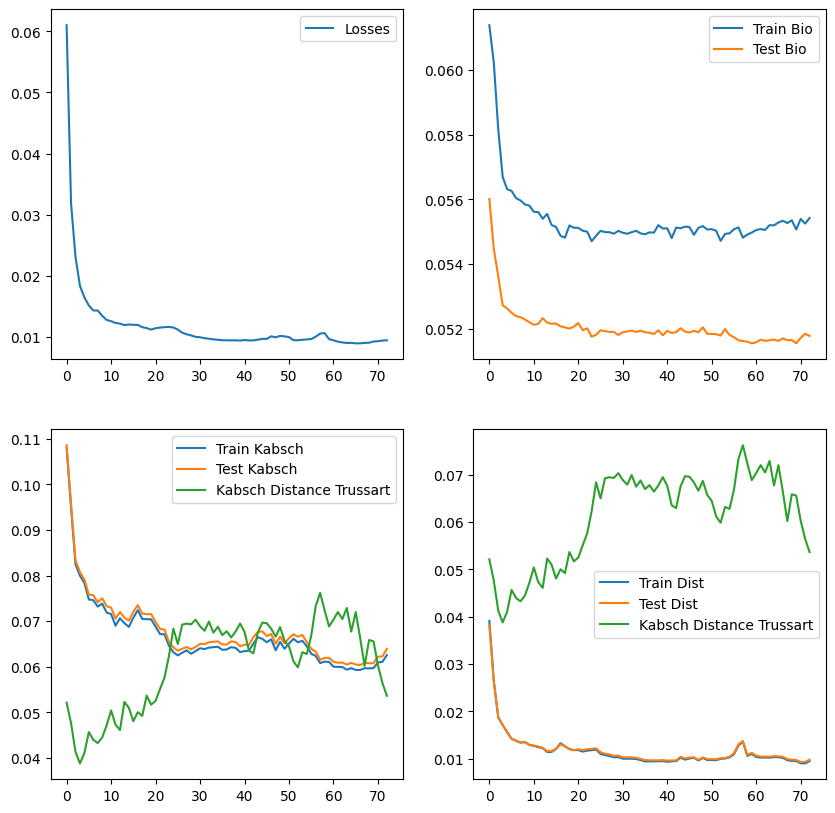

In [11]:
plot_losses(losses, train_biological_losses_all_epochs, test_biological_losses_all_epochs, train_kabsch_losses_all_epochs, test_kabsch_losses_all_epochs, trussart_test_kabsch_losses_all_epochs, train_distance_losses_all_epochs, test_distance_losses_all_epochs)


In [12]:
GRAPH_TESTED = 0

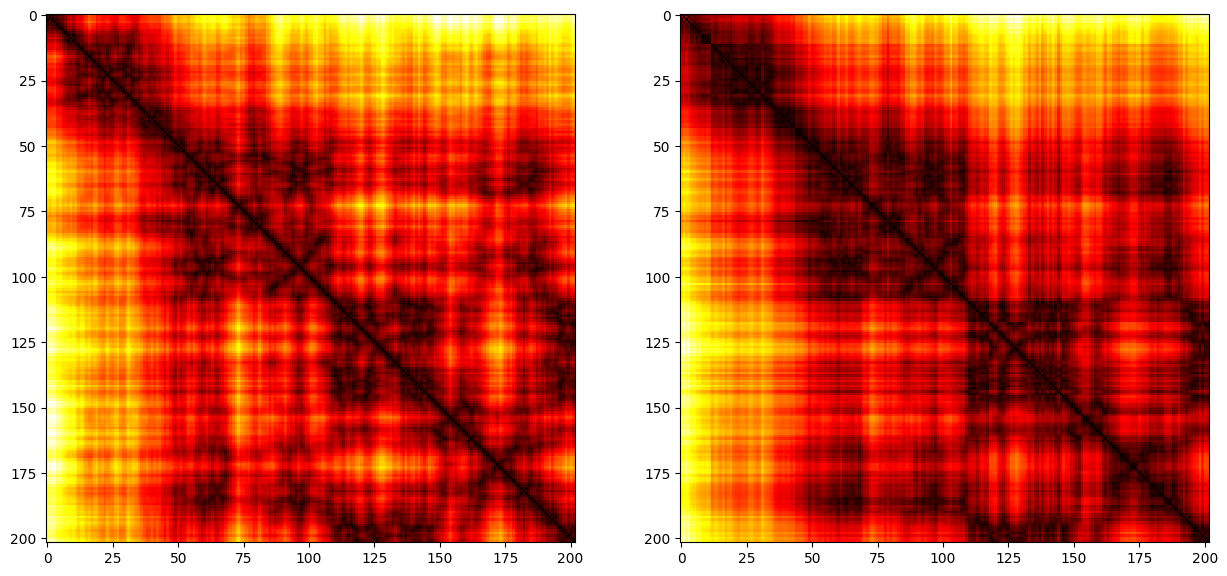

In [13]:
ground_truth_matrix = test_true_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
reconstruction_matrix = test_pred_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
plot_test_distance_matrix(ground_truth_matrix, reconstruction_matrix)

In [14]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.08506639601638899


<Figure size 50000x50000 with 0 Axes>

In [15]:
make_gif("", "gifs/trussart_linear.gif")

In [16]:
# Trussart perfect structure
trussart_true_structure = np.mean(trussart_structures, axis=0)

# Trussart predicted structure
torch_trussart_hic = torch.FloatTensor(trussart_hic)
torch_trussart_hic = torch.reshape(torch_trussart_hic, (1, NB_BINS, NB_BINS))
torch_trussart_hic = torch.repeat_interleave(torch_trussart_hic, BATCH_SIZE, 0)

trussart_pred_structure, _ = model(torch_trussart_hic)
trussart_pred_structure = trussart_pred_structure.detach().numpy()[0]

# Superpose structure using Kabsch algorithm
trussart_pred_structure_superposed, trussart_true_structure_superposed = \
        kabsch_superimposition_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)

# Plot and compare the two structures
x_pred = trussart_pred_structure_superposed[:, 0]  
y_pred = trussart_pred_structure_superposed[:, 1]
z_pred = trussart_pred_structure_superposed[:, 2]

x_true = trussart_true_structure_superposed[:, 0]  
y_true = trussart_true_structure_superposed[:, 1]
z_true = trussart_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)))

Kabsch distance is 0.053683812756332626


<Figure size 50000x50000 with 0 Axes>

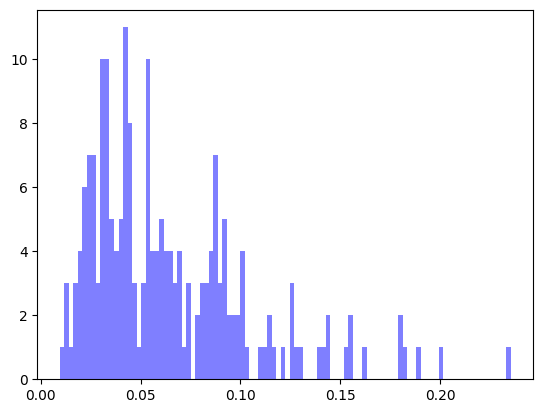

mean: 0.06393556695917446
median: 0.05353621647940878
variance: 0.0016480327038437214


In [17]:
plot_hist_kabsch_distances(test_size, test_true_structures, test_pred_structures, EMBEDDING_SIZE)

In [18]:
RESULTS_ROOT = '../../saved_results/synthetic_biological_trussart_special_values/linear/'
LAMBDA_CONFIGURATION = str(LAMBDA_BIO) + '_' + str(LAMBDA_KABSCH)

In [19]:
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_special_values_linear_losses_' + LAMBDA_CONFIGURATION + '.txt', losses)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_special_values_linear_train_biological_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', train_biological_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_special_values_linear_test_biological_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', test_biological_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_special_values_linear_train_kabsch_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', train_kabsch_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_special_values_linear_test_kabsch_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', test_kabsch_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_special_values_linear_train_distance_losses_all_epochs_' +
           LAMBDA_CONFIGURATION + '.txt', train_distance_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_special_values_linear_test_distance_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', test_distance_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_special_values_linear_trussart_test_kabsch_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', trussart_test_kabsch_losses_all_epochs)

In [20]:
torch.save(model, 
           '../../saved_models/synthetic_biological_trussart_special_values/linear/synthetic_biological_trussart_uniform_linear_model_' + 
           LAMBDA_CONFIGURATION + '.pt')